In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def load_data():
    # Constants
    time = 10
    offset = 100
    folders = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
    classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}

    combined_dir = os.path.join("Combined")

    X_train=[]
    y_train=[]
    dataset_dir = os.path.join(combined_dir,"Train")

    for folder in folders:
        files = os.listdir(os.path.join(dataset_dir,folder))

        for file in files:

            df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
            df = df[offset:offset+time*50]
            X_train.append(df.values)
            y_train.append(classes[folder])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test=[]
    y_test=[]
    dataset_dir = os.path.join(combined_dir,"Test")

    for folder in folders:
        files = os.listdir(os.path.join(dataset_dir,folder))
        for file in files:

            df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
            df = df[offset:offset+time*50]
            X_test.append(df.values)
            y_test.append(classes[folder])

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X = np.concatenate((X_train,X_test))
    y = np.concatenate((y_train,y_test))

    seed = 4
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=seed,stratify=y)

    print("Training data shape: ",X_train.shape)
    print("Testing data shape: ",X_test.shape)

    return X_train,X_test,y_train,y_test

In [3]:
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
X_train,X_test,y_train,y_test = load_data()

Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)


In [4]:
X_train.shape

(126, 500, 3)

In [11]:
import torch

# Ensure X_train and y_train are PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long) - 1  # Shift labels to 0-based index
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long) - 1  # Shift labels to 0-based index

# Ensure labels are in correct range
print("Unique train labels:", torch.unique(y_train))
print("Unique test labels:", torch.unique(y_test))

# Create dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Unique train labels: tensor([0, 1, 2, 3, 4, 5])
Unique test labels: tensor([0, 1, 2, 3, 4, 5])


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_layers=2, num_classes=6, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x) 
        out = self.dropout(lstm_out[:, -1, :])  
        return self.fc(out)

lstm_model = LSTMModel()
print(lstm_model)


LSTMModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=64, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
class CNN1DModel(nn.Module):
    def __init__(self, input_dim=3, num_classes=6, dropout=0.5):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout)

        self._to_linear = None  # Dynamically calculate FC layer input size
        self._compute_flattened_size()

        self.fc = nn.Linear(self._to_linear, num_classes)

    def _compute_flattened_size(self):
        """ Runs a dummy forward pass to compute the flattened size for FC layer """
        with torch.no_grad():
            x = torch.randn(1, 500, 3)  
            x = x.permute(0, 2, 1)
            x = self.pool(torch.relu(self.conv1(x)))
            x = self.dropout(x)
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.dropout(x)
            self._to_linear = x.numel()  

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)  
        x = self.dropout(x)
        return self.fc(x)

cnn_model = CNN1DModel()
print(cnn_model)


CNN1DModel(
  (conv1): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16000, out_features=6, bias=True)
)


In [20]:
def train_model(model, train_loader, test_loader, num_epochs=50,patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_test_loss = np.inf
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss, correct_train = 0, 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct_train += (outputs.argmax(1) == y_batch).sum().item()

        train_acc = correct_train / len(train_loader.dataset)

        # Test Accuracy
        model.eval()
        total_test_loss, correct_test = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_loss = criterion(outputs, y_batch)
                total_test_loss += test_loss.item()
                correct_test += (outputs.argmax(1) == y_batch).sum().item()

        test_acc = correct_test / len(test_loader.dataset)

        print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {total_test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # Early Stopping (optional)
        if total_test_loss < best_test_loss:
            best_test_loss = total_test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


In [21]:
print("Training LSTM Model...")
train_model(lstm_model, train_loader, test_loader)

print("Training CNN Model...")
train_model(cnn_model, train_loader, test_loader)


Training LSTM Model...
Epoch 1, Train Loss: 10.0817, Train Acc: 0.4206, Test Loss: 4.5198, Test Acc: 0.4815
Epoch 2, Train Loss: 10.0151, Train Acc: 0.3889, Test Loss: 4.3870, Test Acc: 0.4815
Epoch 3, Train Loss: 9.6951, Train Acc: 0.4841, Test Loss: 4.3258, Test Acc: 0.5000
Epoch 4, Train Loss: 9.5409, Train Acc: 0.4683, Test Loss: 4.4472, Test Acc: 0.5370
Epoch 5, Train Loss: 9.6276, Train Acc: 0.4444, Test Loss: 4.3968, Test Acc: 0.4815
Epoch 6, Train Loss: 9.3717, Train Acc: 0.4444, Test Loss: 4.3505, Test Acc: 0.4815
Epoch 7, Train Loss: 9.5903, Train Acc: 0.4524, Test Loss: 4.3182, Test Acc: 0.4630
Epoch 8, Train Loss: 9.8426, Train Acc: 0.4365, Test Loss: 4.3016, Test Acc: 0.4815
Epoch 9, Train Loss: 9.9498, Train Acc: 0.4444, Test Loss: 4.3813, Test Acc: 0.4630
Epoch 10, Train Loss: 10.0277, Train Acc: 0.4048, Test Loss: 4.3554, Test Acc: 0.4630
Epoch 11, Train Loss: 9.6053, Train Acc: 0.4365, Test Loss: 4.2911, Test Acc: 0.4630
Epoch 12, Train Loss: 9.8418, Train Acc: 0.3889,

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def get_predictions(model, test_loader):
    """ Gets true and predicted labels from the test set. """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model(X_batch)
            predictions = outputs.argmax(1)

            y_true.extend(y_batch.cpu().numpy())  
            y_pred.extend(predictions.cpu().numpy())  

    return y_true, y_pred


In [23]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """ Plots a confusion matrix for a given model. """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


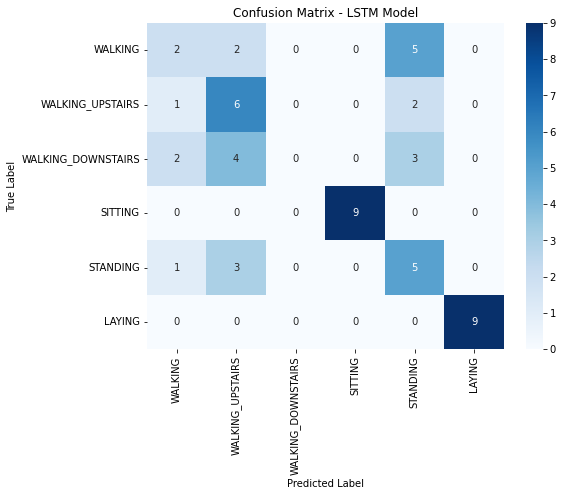

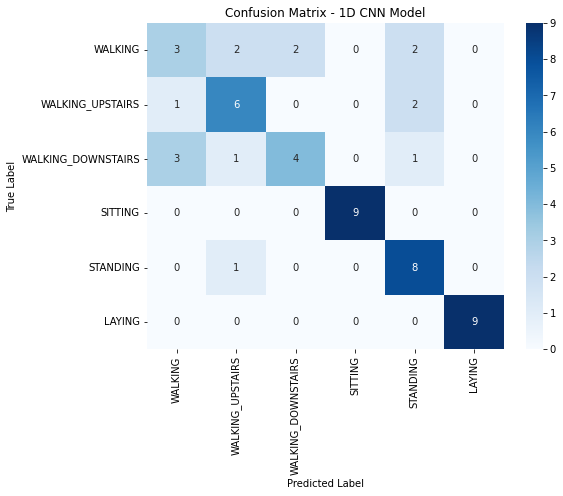

In [24]:
# Evaluate LSTM Model
y_true_lstm, y_pred_lstm = get_predictions(lstm_model, test_loader)
plot_confusion_matrix(y_true_lstm, y_pred_lstm, "LSTM Model")

# Evaluate CNN Model
y_true_cnn, y_pred_cnn = get_predictions(cnn_model, test_loader)
plot_confusion_matrix(y_true_cnn, y_pred_cnn, "1D CNN Model")
